
# Face Stylizer App St





dated:22/dec/2024
1. link docs:https://github.com/google-ai-edge/mediapipe-samples/blob/main/examples/face_stylizer/python/face_stylizer.ipynb
2. this notebook have backend and app code.

In [1]:
!pip install -q mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 34.1 MB/s eta 0:00:00


In [29]:
#@title Start downloading here.
!wget -O face_stylizer.task -q https://storage.googleapis.com/mediapipe-models/face_stylizer/blaze_face_stylizer/float32/latest/face_stylizer_color_sketch.task

In [34]:
import urllib
IMAGE_FILENAMES = ['business-person.png']

for name in IMAGE_FILENAMES:
  url = f'https://storage.googleapis.com/mediapipe-assets/{name}'
  urllib.request.urlretrieve(url, name)

business-person.png


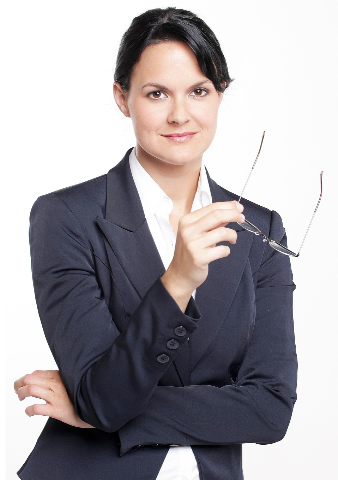

In [31]:
import cv2
from google.colab.patches import cv2_imshow
import math

# Height and width that will be used by the model
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

# Performs resizing and showing the image
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)


# Preview the image(s)
images = {name: cv2.imread(name) for name in IMAGE_FILENAMES}
for name, image in images.items():
  print(name)
  resize_and_show(image)

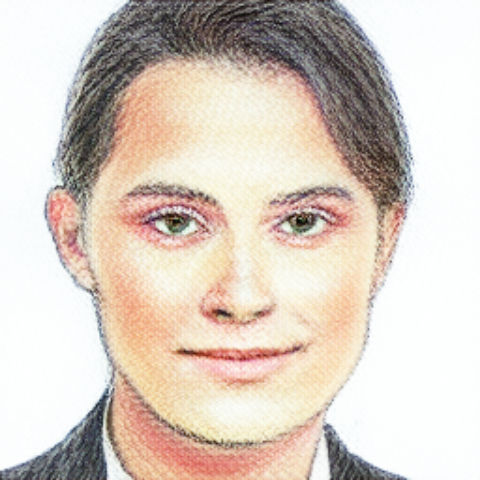

In [32]:
import numpy as np
import mediapipe as mp

from mediapipe.tasks import python
from mediapipe.tasks.python import vision


# Create the options that will be used for FaceStylizer
base_options = python.BaseOptions(model_asset_path='face_stylizer.task')
options = vision.FaceStylizerOptions(base_options=base_options)

# Create the face stylizer
with vision.FaceStylizer.create_from_options(options) as stylizer:

  # Loop through demo image(s)
  for image_file_name in IMAGE_FILENAMES:

    # Create the MediaPipe image file that will be stylized
    image = mp.Image.create_from_file(image_file_name)
    # Retrieve the stylized image
    stylized_image = stylizer.stylize(image)

    # Show the stylized image
    rgb_stylized_image = cv2.cvtColor(stylized_image.numpy_view(), cv2.COLOR_BGR2RGB)
    resize_and_show(rgb_stylized_image)

# Streamlit APP

In [ ]:
#!wget -O face_stylizer.task https://storage.googleapis.com/mediapipe-models/face_stylizer/blaze_face_stylizer/float32/latest/face_stylizer_color_sketch.task

In [ ]:
#!pip install streamlit mediapipe opencv-python numpy

In [35]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.3 MB/s eta 0:00:00


In [40]:
%%writefile app.py
import streamlit as st
import cv2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import math

# Set page config
st.set_page_config(page_title="Face Stylizer App", layout="wide")
st.title("Face Stylizer App")

def resize_image(image, desired_height=480, desired_width=480):
    h, w = image.shape[:2]
    if h < w:
        img = cv2.resize(image, (desired_width, math.floor(h/(w/desired_width))))
    else:
        img = cv2.resize(image, (math.floor(w/(h/desired_height)), desired_height))
    return img

def preprocess_image(image):
    alpha = 1.2
    beta = 10
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    max_dimension = 1024
    height, width = adjusted.shape[:2]
    if max(height, width) > max_dimension:
        scale = max_dimension / max(height, width)
        adjusted = cv2.resize(adjusted, None, fx=scale, fy=scale)

    return adjusted

# Create two columns
col1, col2 = st.columns(2)

# File uploader in the first column
with col1:
    st.subheader("Upload Image")
    uploaded_file = st.file_uploader("Choose an image...", type=['jpg', 'jpeg', 'png'])

    if uploaded_file is not None:
        # Convert the file to an opencv image.
        file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
        original_image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

        # Display original image
        st.image(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB), caption='Original Image')

# Stylize button and result in the second column
with col2:
    st.subheader("Stylized Result")
    if uploaded_file is not None:
        if st.button('Apply Style'):
            with st.spinner('Applying style...'):
                try:
                    # Preprocess the image
                    processed_image = preprocess_image(original_image)

                    # Create MediaPipe image
                    mp_image = mp.Image(
                        image_format=mp.ImageFormat.SRGB,
                        data=processed_image
                    )

                    # Create the options for FaceStylizer
                    base_options = python.BaseOptions(model_asset_path='face_stylizer.task')
                    options = vision.FaceStylizerOptions(base_options=base_options)

                    # Create the face stylizer and process the image
                    with vision.FaceStylizer.create_from_options(options) as stylizer:
                        stylized_image = stylizer.stylize(mp_image)
                        rgb_stylized_image = cv2.cvtColor(
                            stylized_image.numpy_view(),
                            cv2.COLOR_BGR2RGB
                        )

                        # Display stylized image
                        st.image(rgb_stylized_image, caption='Stylized Image')

                except Exception as e:
                    st.error(f"Error processing image: {str(e)}")

# Add instructions and information
st.markdown("""
### Instructions:
1. Click 'Browse files' to upload your image
2. Wait for the image to load
3. Click 'Apply Style' to generate the stylized version
4. Wait for the processing to complete

### Notes:
- Works best with clear, front-facing portraits
- Good lighting and image quality will improve results
- Only one face should be clearly visible in the image
""")

# Add download capability for the stylized image
if 'rgb_stylized_image' in locals():
    st.download_button(
        label="Download stylized image",
        data=cv2.imencode('.png', cv2.cvtColor(rgb_stylized_image, cv2.COLOR_RGB2BGR))[1].tobytes(),
        file_name="stylized_image.png",
        mime="image/png"
    )

Writing app.py


In [36]:
!pip install pyngrok

In [37]:
import os
from threading import Thread
from pyngrok import ngrok


In [38]:
from google.colab import userdata

# Retrieve the Ngrok API key securely
ngrok_api_key = userdata.get('NGROK_API')

if ngrok_api_key:
    # Authenticate Ngrok with the API key
    ngrok.set_auth_token(ngrok_api_key)
    print("Ngrok authenticated successfully!")
else:
    print("Ngrok API key not found. Please add it in the Colab settings.")

Ngrok authenticated successfully!


In [39]:
# Add your ngrok token here
ngrok.set_auth_token(ngrok_api_key)

In [41]:
def run_streamlit():
    # Change the port if 8501 is already in use or if you prefer another port
    os.system('streamlit run /content/app.py --server.port 8501')


In [42]:
# Start a thread to run the Streamlit app
thread = Thread(target=run_streamlit)
thread.start()

In [43]:
# Open a tunnel to the streamlit port 8501
public_url = ngrok.connect(addr='8501', proto='http', bind_tls=True)
print('Your Streamlit app is live at:', public_url)


Your Streamlit app is live at: NgrokTunnel: "https://a332-35-229-251-151.ngrok-free.app" -> "http://localhost:8501"


In [44]:
ngrok.kill()